In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
%env MLPERF_HPC_ROOT=/home/lukasd/src/mlperf

%env MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP=data_benchmark/test

env: MLPERF_HPC_ROOT=/home/lukasd/src/mlperf
env: MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP=data_benchmark/test


In [5]:
%%bash

echo "## Data benchmark experiments ##"
set -x
ls -l ${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}
set +x

## Data benchmark experiments ##
total 12
drwxr-xr-x 2 lukasd lukasd 4096 Aug  4 21:06 gpu-n1
drwxr-xr-x 2 lukasd lukasd 4096 Aug  4 21:06 gpu-n2
drwxr-xr-x 2 lukasd lukasd 4096 Aug  4 21:06 gpu-n4


+ ls -l /home/lukasd/src/mlperf/cosmoflow-benchmark/results/data_benchmark/test
+ set +x


In [6]:

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'data_benchmark_history.csv')
    history = pd.read_csv(history_file)
    for col in ['local_times', 'global_times']:
        history[col] = history[col].apply(lambda x: np.fromstring(x.strip('[]'), dtype=float, sep=' '))
    print(history)
    return history

result_dir = os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}/gpu-n%i') % 2
load_result(result_dir)


   Unnamed: 0  epoch               local_times              global_times
0           0      0     [1.595076, 1.5842603]    [1.7081851, 1.7198099]
1           1      1   [0.1838269, 0.18297279]  [0.40480858, 0.40720072]
2           2      2  [0.10202301, 0.15979803]  [0.35095358, 0.33739594]
3           3      3  [0.09010007, 0.05773859]  [0.10093708, 0.10180598]


,Unnamed: 0,epoch,local_times,global_times
0,0,0,"[1.595076, 1.5842603]","[1.7081851, 1.7198099]"
1,1,1,"[0.1838269, 0.18297279]","[0.40480858, 0.40720072]"
2,2,2,"[0.10202301, 0.15979803]","[0.35095358, 0.33739594]"
3,3,3,"[0.09010007, 0.05773859]","[0.10093708, 0.10180598]"


In [7]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'data_benchmark_history.csv')
    history = pd.read_csv(history_file)
    for col in ['local_times', 'global_times']:
        history[col] = history[col].apply(lambda x: np.fromstring(x.strip('[]'), dtype=float, sep=' '))
    return history

def get_num_samples(config, ranks):
    dconf = config['data']
    n = dconf['n_train'] + dconf['n_valid']
    if not dconf['shard']:
        n *= ranks
    return n


def compute_epoch_selection_summary(n_ranks, n_samples, benchmark_history):
    if isinstance(benchmark_history, pd.Series):
        local_times = benchmark_history['local_times']
        global_times = benchmark_history['global_times']
    else:
        local_times = np.vstack(benchmark_history['local_times'].to_numpy())
        global_times = np.vstack(benchmark_history['global_times'].to_numpy())

    #import pydevd_pycharm
    #pydevd_pycharm.settrace('localhost', port=23232, stdoutToServer=True, stderrToServer=True)    
    
    local_throughputs = n_samples / (n_ranks*local_times)
    global_throughputs = n_samples / global_times

    return dict(total_time_mean=np.mean(global_times),
                total_time_std=np.std(global_times),
                local_throughput_mean=np.mean(local_throughputs),
                local_throughput_std=np.std(local_throughputs),
                total_throughput_mean=np.mean(global_throughputs),
                total_throughput_std=np.std(global_throughputs))


def compute_data_benchmark_summary(n_ranks, n_samples, benchmark_history):

    initial_epoch_stats = { k : v for k,v in 
                           compute_epoch_selection_summary(n_ranks, n_samples, 
                                                           benchmark_history.loc[0]).items() }
    if benchmark_history.shape[0] > 1:
        later_epoch_stats = { k : v for k,v in 
                             compute_epoch_selection_summary(n_ranks, n_samples, 
                                                             benchmark_history[benchmark_history['epoch'] > 0]).items() }
    else:
        later_epoch_stats = {}
    return dict(ranks=n_ranks, samples=n_samples, **initial_epoch_stats), \
           dict(ranks=n_ranks, samples=n_samples, **later_epoch_stats)
 

def compute_scaling(stats):

    stats['local_ideal'] = stats.ranks.apply(lambda r: 1.) * stats['local_throughput_mean'].loc[0]
    stats['local_eff']   = stats.apply(lambda result: result['local_throughput_mean']/result['local_ideal'], axis=1)

    stats['total_ideal'] = stats.ranks * stats['total_throughput_mean'].loc[0]
    stats['total_eff']   = stats.apply(lambda result: result['total_throughput_mean']/result['total_ideal'], axis=1)    

    return stats
    
def get_scaling_results(path_pattern, ranks):
    """
    Loops over ranks with specified file path pattern and computes scaling metrics.
    Returns results in a dataframe.
    """    
    configs, results = [], []
    for r in ranks:
        result_dir = path_pattern % r
        configs.append(load_config(result_dir))
        results.append(load_result(result_dir))
    samples = np.array([get_num_samples(c,r) for (c,r) in zip(configs, ranks)])    
    init_stats_l, later_stats_l = \
        zip(*[compute_data_benchmark_summary(rank,n,res) for (rank,n,res) in zip(ranks, samples, results)])
    
    # Data analysis starts here - if different scaling behavior desired, replace the next two lines
    init_stats  = compute_scaling(pd.DataFrame.from_records(init_stats_l))
    later_stats = compute_scaling(pd.DataFrame.from_records(later_stats_l))
    
    stats = init_stats.merge(later_stats, on=['ranks','samples'], suffixes=('_init','_later'))

    return stats


In [8]:
results = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}/gpu-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64, 128]))
results
#results.to_csv(...)

,ranks,samples,total_time_mean_init,total_time_std_init,local_throughput_mean_init,local_throughput_std_init,total_throughput_mean_init,total_throughput_std_init,local_ideal_init,local_eff_init,...,total_time_mean_later,total_time_std_later,local_throughput_mean_later,local_throughput_std_later,total_throughput_mean_later,total_throughput_std_later,local_ideal_later,local_eff_later,total_ideal_later,total_eff_later
0,1,8,0.859318,0.000000,10.041857,0.000000,9.309706,0.000000,10.041857,1.000000,...,0.150340,0.071644,114.795650,64.329503,76.517709,50.233100,114.79565,1.000000,76.517709,1.000000
1,2,16,1.713998,0.005812,5.032555,0.017120,9.335010,0.031656,10.041857,0.501158,...,0.283850,0.131538,73.844018,33.725074,81.250984,54.236780,114.79565,0.643265,153.035418,0.530929
2,4,32,4.160750,0.024109,2.325857,0.081113,7.691179,0.044601,10.041857,0.231616,...,1.126995,0.756101,62.211677,33.615056,100.983110,113.993878,114.79565,0.541934,306.070836,0.329934


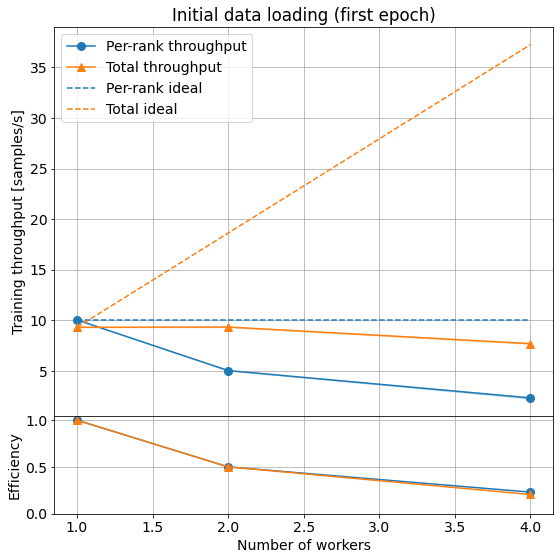

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Initial data loading (first epoch)')
ax0.plot(results.ranks, results.local_throughput_mean_init, 'o-',  ms=8, label='Per-rank throughput', color='tab:blue')
ax0.fill_between(results.ranks, results.local_throughput_mean_init - results.local_throughput_std_init, results.local_throughput_mean_init + results.local_throughput_std_init, alpha=0.2, color='tab:blue')
ax0.plot(results.ranks, results.total_throughput_mean_init, '^-', ms=8, label='Total throughput', color='tab:orange')
ax0.fill_between(results.ranks, results.total_throughput_mean_init - results.total_throughput_std_init, results.total_throughput_mean_init + results.total_throughput_std_init, alpha=0.2, color='tab:orange')
ax0.plot(results.ranks, results.local_ideal_init, '--',  label='Per-rank ideal', color='tab:blue')
ax0.plot(results.ranks, results.total_ideal_init, '--', label='Total ideal', color='tab:orange')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.local_eff_init, 'o-', ms=8, color='tab:blue')
ax1.plot(results.ranks, results.total_eff_init, '^-', ms=8, color='tab:orange')
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.)
ax1.grid()

plt.tight_layout()

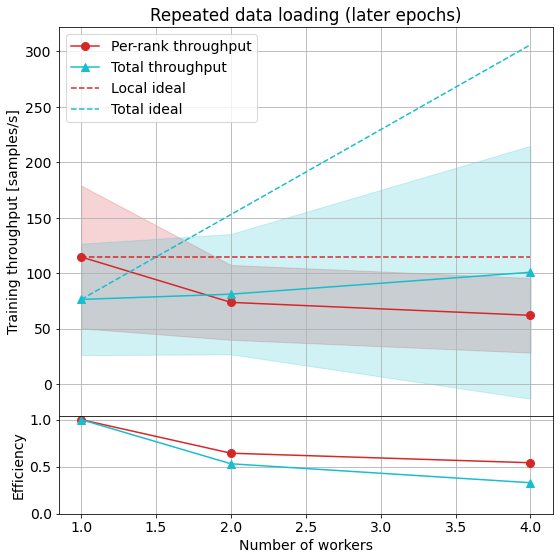

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Repeated data loading (later epochs)')
ax0.plot(results.ranks, results.local_throughput_mean_later, 'o-',  ms=8, label='Per-rank throughput', color='tab:red')
ax0.fill_between(results.ranks, results.local_throughput_mean_later - results.local_throughput_std_later, results.local_throughput_mean_later + results.local_throughput_std_later, alpha=0.2, color='tab:red')
ax0.plot(results.ranks, results.total_throughput_mean_later, '^-', ms=8, label='Total throughput', color='tab:cyan')
ax0.fill_between(results.ranks, results.total_throughput_mean_later - results.total_throughput_std_later, results.total_throughput_mean_later + results.total_throughput_std_later, alpha=0.2, color='tab:cyan')
ax0.plot(results.ranks, results.local_ideal_later, '--',  label='Local ideal', color='tab:red')
ax0.plot(results.ranks, results.total_ideal_later, '--', label='Total ideal', color='tab:cyan')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.local_eff_later, 'o-', ms=8, color='tab:red')
ax1.plot(results.ranks, results.total_eff_later, '^-', ms=8, color='tab:cyan')
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.)
ax1.grid()

plt.tight_layout()